# Homework 2: Emergent communication models

This homework assignment is to be completed in groups. It is due on December 18, 2025 (midnight). Please upload *all files you created or modified* to the homework folder of your group in studIP.

Group number:

Names:

*General note: It is permitted to use AI tools for coding. Please refer to the uploaded manual `AI_Tools_Guidelines` for recommended ways how to use AI to advance your studies in a way that supports your learning. That means that you should not be satisfied if an AI tool hands you a working version of your code, but that you should put in effort to understand how exactly the problem is solved. Another note of caution: What might work for large programming languages like Python, does not necessarily work for Stan. Check your code carefully and do NOT blindly trust AI.*

## Introduction
In the past weeks, you learned about classical neural network approaches to modeling language, about Reinforcement learning and how these two can be combined with the aim of modeling communication in the emergent communication modeling framework.
The goal of this homework assignment is to learn to apply these models. You will be working with a Github repository of my own research. Learning how to work with this repository will qualify you for conducting your study project or thesis within this project.
Below, you receive a sample project and are guided through the steps of conducting it. For all steps, it is expected that you comment your code, explain what you are doing and why, and interpret all your outcomes and results. 

## 1) Creating the environment and installing packages (non-graded)
This is a prerequisite for the following tasks and is therefore non-graded. Please let me know if you run into problems with installing everything. Follow the installation guide in the [emergent-abstractions repository](https://github.com/kristinakobrock/emergent-abstractions/tree/main) and validate that you can run the training (with a small number of epochs and dataset). Follow the tutorial in the [Tutorial Github repository](https://github.com/kristinakobrock/tutorial-emergent-abstractions/tree/main) to make yourself familiar with the code.

For the following tasks, you can either work directly with the main repository (recommended) or work with the tutorial code.

## 2) Dataset (18 points)
The goal is to implement a hierarchical dataset that follows the following logic from the paper by Hawkins et al., 2018: [Emerging abstractions](https://escholarship.org/uc/item/81s4d7fv)
<img src="./img/hierarchy.png" width="400"/>
It differs from the default dataset because the default dataset includes all combinations of objects without implementing a hierarchy. Consider the following example for the default dataset with 3 attributes and 3 values. Concepts are implemented as tuples of objects and fixed vectors which indicate which attributes are relevant to the concept, e.g. ([[2,1,1],[1,0,1],[1,2,1]],(0,0,1)). Where the fixed vector (0,0,1) indicates that only the third attribute is relevant to the concept. [2,1,1],[1,0,1],[1,2,1] are possible objects that satisfy this constraint. You can think of the objects as being a small red circle, a large blue circle and a large green circle - all belonging to the concept 'circle'. Now, in the default dataset, all combinations of attributes are possible, i.e. the higher-level concept don't need to be circles, but could also be the color dimension or the size dimension by specifying the fixed vector as (1,0,0) or (0,1,0). While this certainly makes a lot of sense for compositional features as the ones used here, natural concepts are structured in taxonomic hierarchies (e.g., dalmatian, dog, animal). The goal here is to implement a hierarchical dataset.

### 2.1) Adapting the dataset (12 points)
Adapt the function `get_fixed_vectors` in `dataset.py` to account for hierarchically structured concepts.
Your solution should work for varying dataset sizes and be neatly integrated with the currently available code. Specify a folder where the results for this experiment should be saved to.

### 2.2) Creating the datasets (6 points)
Use the script `pickle_ds.py` to construct 3 datasets with the following attribute-value combinations D(attributes, values):
- D(3,4)
- D(4,4)
- D(3,8)

In [1]:
# Need to be run only once, datasets are saved locally

# D(3,4) --> three attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 
# D(4,4) --> four attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 4
# D(3,8) --> eight attributes with eight values each
!python pickle_ds.py --dimensions 8 8 8

# after changing get_fixed_vector() 
# D(3,4) --> three attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 --hierarchical
# D(4,4) --> four attributes with four values each
!python pickle_ds.py --dimensions 4 4 4 4 --hierarchical
# D(3,8) --> eight attributes with eight values each
!python pickle_ds.py --dimensions 8 8 8 --hierarchical



Creating train_ds and val_ds...
100%|███████████████████████████████████████████| 99/99 [00:02<00:00, 34.42it/s]

Creating test_ds...
100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 60.80it/s]
Data set is saved as: data/standard/dim(3,4)_sf10.ds
Creating train_ds and val_ds...
100%|█████████████████████████████████████████| 499/499 [00:17<00:00, 28.56it/s]

Creating test_ds...
100%|█████████████████████████████████████████| 125/125 [00:04<00:00, 27.77it/s]
Data set is saved as: data/standard/dim(4,4)_sf10.ds
Creating train_ds and val_ds...
100%|█████████████████████████████████████████| 582/582 [00:17<00:00, 33.60it/s]

Creating test_ds...
100%|█████████████████████████████████████████| 146/146 [00:04<00:00, 33.70it/s]
Data set is saved as: data/standard/dim(3,8)_sf10.ds
Creating train_ds and val_ds...
100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 52.73it/s]

Creating test_ds...
100%|███████████████████████████████████████████| 25/25 [00:00

In [1]:
# import Python packages
from argparse import Namespace
import torch
# print(torch.__version__)
# import torch.utils.data
import torch.nn as nn
import egg.core as core
import os
import pickle
import itertools
import yaml

# import modules from files
import dataset as dataset
from archs import Sender, Receiver
from language_analysis_local import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-3',   # sets the learning rate for the selected optimizer 
                         '--batch_size=32',
                         '--optimizer=adam'])

def load_config(path: str) -> Namespace:
    """Read a yaml file and return an argparse.Namespace."""
    with open(path, 'r') as f:
        cfg_dict = yaml.safe_load(f)          # → plain dict
    return Namespace(**cfg_dict) 

# dataset split
SPLIT = (0.6, 0.2, 0.2)

In [2]:
def set_vocab_size_msg_len(opts):
    # vocab size and message length
    opts.dimensions = list(itertools.repeat(opts.values, opts.attributes))
    vocab_size = opts.vocab_size_user

    # allow user to specify a maximum message length
    if opts.max_mess_len > 0:
        max_len = opts.max_mess_len
    # default: number of attributes
    else:
        max_len =  max(len(opts.dimensions), 5)
    
    return vocab_size, max_len


In [3]:
def setup_folder_structure(opts, hierarchical=False):
    # set up folders for saving
    if not os.path.exists('data'):
            os.makedirs('data')
    if not os.path.exists('results'):
        os.makedirs('results')

    # file_path = f"{path}/{context_aware_path}/{run_path}/{file_name}.{file_extension}"

        
    data_set_name = '(' + str(len(opts.dimensions)) + ',' + str(opts.dimensions[0]) + ')'
    folder_name = (data_set_name + '_game_size_' + str(opts.game_size))

    # define game setting from args
    if opts.context_unaware:
        opts.game_setting = 'context_unaware'
    else:
        opts.game_setting = 'context_aware'

    if hierarchical:
        hierarchical_path = 'hierarchical'
    else:
        hierarchical_path = 'standard'

    path_name = os.path.join(opts.path, 'results', hierarchical_path, folder_name)

    # create subfolders if necessary
    opts.game_path = os.path.join(path_name, opts.game_setting)
    if not os.path.exists(opts.game_path):
        os.makedirs(opts.game_path)

    # saving
    if opts.save:
        # make folder for new run
        latest_run = len(os.listdir(opts.game_path))
        opts.save_path = os.path.join(opts.game_path, str(latest_run))
        if not os.path.exists(opts.save_path):
            os.makedirs(opts.save_path)
        pickle.dump(opts, open(opts.save_path + '/params.pkl', 'wb'))
        save_epoch = opts.n_epochs
    else:
        save_epoch = None



In [4]:
def load_dataset(opts):

    if opts.load_dataset == '':
        data_set = dataset.DataSet(opts.dimensions,
                                game_size=opts.game_size,
                                scaling_factor=opts.scaling_factor,
                                device=device)
    else:
        # load the dataset specified in the opts
        data_set = torch.load(opts.path + 'data/' + opts.load_dataset, weights_only=False)
        print('data loaded from: ' + 'data/' + opts.load_dataset)
        
    train, val, test = data_set

    dimensions = train.dimensions

    train = torch.utils.data.DataLoader(train, batch_size=opts.batch_size, shuffle=True)
    val = torch.utils.data.DataLoader(val, batch_size=opts.batch_size, shuffle=False, drop_last=True)
    test = torch.utils.data.DataLoader(test, batch_size=opts.batch_size, shuffle=False)

    return dimensions, train, val, test

In [5]:
def loss(_sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    Loss needs to be defined for gumbel softmax relaxation.
    For a discriminative game, accuracy is computed by comparing the index with highest score in Receiver
    output (a distribution of unnormalized probabilities over target positions) and the corresponding 
    label read from input, indicating the ground-truth position of the target.
    Adaptation to concept game with multiple targets after Mu & Goodman (2021) with BCEWithLogitsLoss
        receiver_output: Tensor of shape [batch_size, n_objects]
        labels: Tensor of shape [batch_size, n_objects]
    """
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(receiver_output, labels)
    receiver_pred = (receiver_output > 0).float()
    per_game_acc = (receiver_pred == labels).float().mean(1).cpu().numpy()  # all labels have to be predicted correctly
    acc = per_game_acc.mean()
    return loss, {'acc': acc}

In [6]:
def game_setup(dimensions, vocab_size, max_len, opts):
    # Game
    # initialize sender and receiver agents
    sender = Sender(opts.hidden_size, sum(dimensions), opts.game_size, opts.context_unaware)
    receiver = Receiver(sum(dimensions), opts.hidden_size)

    # initialize game
    sender = core.RnnSenderGS(sender,
                            vocab_size,
                            int(opts.hidden_size / 2),
                            opts.hidden_size,
                            cell=opts.sender_cell,
                            max_len=max_len,
                            temperature=opts.temperature)

    receiver = core.RnnReceiverGS(receiver,
                                vocab_size,
                                int(opts.hidden_size / 2),
                                opts.hidden_size,
                                cell=opts.receiver_cell)

    game = core.SenderReceiverRnnGS(sender, receiver, loss, length_cost=opts.length_cost)
    return game, sender

In [7]:
def train_and_callbacks(game, sender, save_epoch, train, val, opts):
    # Training
    # set optimizer
    optimizer = torch.optim.Adam([
        {'params': game.sender.parameters(), 'lr': opts.learning_rate},
        {'params': game.receiver.parameters(), 'lr': opts.learning_rate}
    ])

    # setup training and callbacks
    # results/ data set name/ kind_of_dataset/ run/
    callbacks = [SavingConsoleLogger(print_train_loss=True, as_json=True,
                                    save_path=opts.save_path, save_epoch=save_epoch),
                core.TemperatureUpdater(agent=sender, decay=opts.temp_update, minimum=0.5)]
    if opts.save:
        callbacks.extend([core.callbacks.InteractionSaver([opts.n_epochs],
                                                        test_epochs=[opts.n_epochs],
                                                        checkpoint_dir=opts.save_path),
                        core.callbacks.CheckpointSaver(opts.save_path, checkpoint_freq=0)])

    trainer = core.Trainer(game=game, optimizer=optimizer,
                        train_data=train, validation_data=val, callbacks=callbacks, device=device)

    # if checkpoint path is given, load checkpoint and skip training
    if opts.load_checkpoint:
        trainer.load_from_checkpoint(opts.checkpoint_path, map_location=device)
    else:
        trainer.train(n_epochs=opts.n_epochs)
    
    return trainer


In [8]:
def test_training(trainer, test, opts):
    # after training evaluate performance on the test data set
    if len(test):
        trainer.validation_data = test
        eval_loss, interaction = trainer.eval()
        acc = torch.mean(interaction.aux['acc']).item()
        print("test accuracy: " + str(acc))
        if opts.save:
            loss_and_metrics_path = os.path.join(opts.save_path, 'loss_and_metrics.pkl')
            if os.path.exists(loss_and_metrics_path):
                with open(loss_and_metrics_path, 'rb') as pickle_file:
                    loss_and_metrics = pickle.load(pickle_file)
            else:
                loss_and_metrics = {}

            loss_and_metrics['final_test_loss'] = eval_loss
            loss_and_metrics['final_test_acc'] = acc
            pickle.dump(loss_and_metrics, open(opts.save_path + '/loss_and_metrics.pkl', 'wb'))



In [9]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
plt.style.use('default')
import random
import seaborn

from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import *

In [11]:
configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_4_4.yml', 'config_hierarchical_3_8.yml',
           'config_standard_3_4.yml', 'config_standard_4_4.yml', 'config_standard_3_8.yml']

n_runs = 5

for file in configs:
    for n in range(n_runs):   
        opts = load_config(file)
        vocab_size, max_len = set_vocab_size_msg_len(opts)
        dimensions, train, val, test = load_dataset(opts)
        if "hierarchical" in file:
            folder_name = setup_folder_structure(opts, hierarchical=True)
        else:
            folder_name = setup_folder_structure(opts, hierarchical=False)

        game, sender = game_setup(dimensions, vocab_size, max_len, opts)
    
        trainer = train_and_callbacks(game, sender, save_epoch=opts.n_epochs, train=train, val=val, opts=opts)
        test_training(trainer, test, opts)

    
    

data loaded from: data/hierarchical/dim(3,4)_sf10.ds
{"loss": 0.6796006560325623, "acc": 0.566921055316925, "length": 4.219819068908691, "mode": "train", "epoch": 1}
{"loss": 0.5926241278648376, "acc": 0.7223442196846008, "length": 5.423611164093018, "mode": "test", "epoch": 1}
{"loss": 0.519368052482605, "acc": 0.7458423376083374, "length": 5.537298679351807, "mode": "train", "epoch": 2}
{"loss": 0.5056909322738647, "acc": 0.7753472924232483, "length": 6.0, "mode": "test", "epoch": 2}
{"loss": 0.4441409707069397, "acc": 0.810828447341919, "length": 5.8936004638671875, "mode": "train", "epoch": 3}
{"loss": 0.5085675120353699, "acc": 0.7671874165534973, "length": 6.0, "mode": "test", "epoch": 3}
{"loss": 0.3859054744243622, "acc": 0.8388411998748779, "length": 5.950101375579834, "mode": "train", "epoch": 4}
{"loss": 0.45875078439712524, "acc": 0.8184895515441895, "length": 6.0, "mode": "test", "epoch": 4}
{"loss": 0.3285331726074219, "acc": 0.8646599650382996, "length": 5.97609376907348

In [12]:
# get save paths separately

def get_dataset_paths(results_root="results"):
    results_root = Path(results_root)
    dataset_paths = set()

    for p in results_root.rglob("*"):
        if p.is_dir() and p.name.isdigit():
            dataset_paths.add(p.parent.parent)

    return sorted(dataset_paths)



[PosixPath('results/hierarchical/(3,4)_game_size_10'), PosixPath('results/hierarchical/(3,8)_game_size_10'), PosixPath('results/hierarchical/(4,4)_game_size_10'), PosixPath('results/standard/(3,4)_game_size_10'), PosixPath('results/standard/(3,8)_game_size_10'), PosixPath('results/standard/(4,4)_game_size_10')]


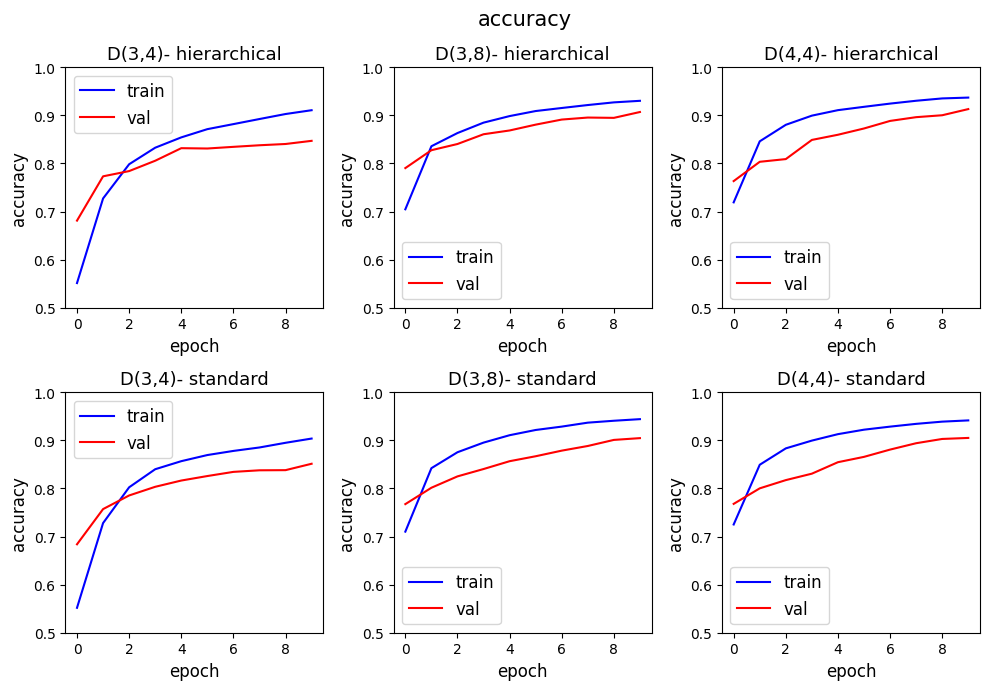

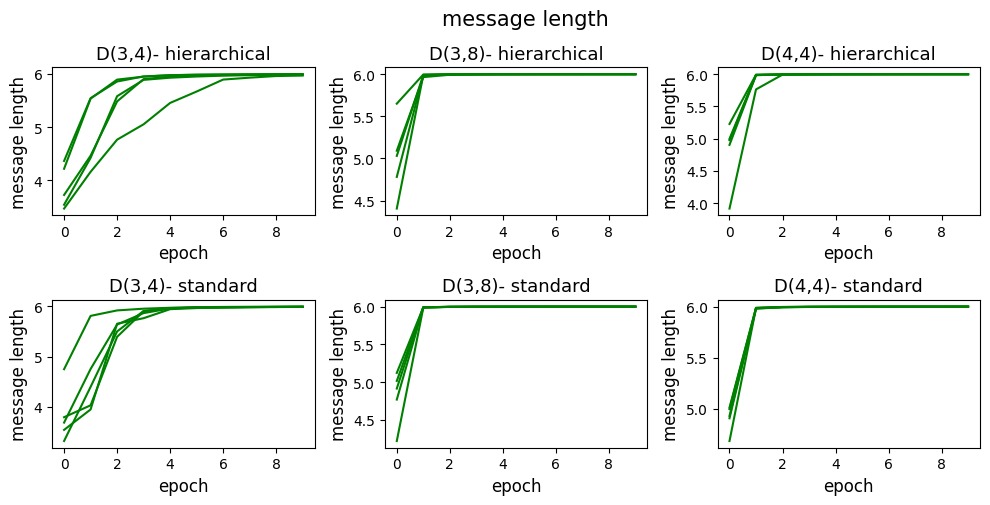

In [31]:
parent_path = os.getcwd()
dataset_paths = get_dataset_paths("results")
print(dataset_paths)

all_accuracies = load_accuracies(dataset_paths, n_runs=5, n_epochs=10, val_steps=1,context_unaware=False)



titles = ("D(3,4)- hierarchical", "D(3,8)- hierarchical", "D(4,4)- hierarchical",
          "D(3,4)- standard", "D(3,8)- standard", "D(4,4)- standard")

train_mean = np.mean(all_accuracies["train_acc"], axis=1)[:, np.newaxis, :]  # shape (6, 1, 10)
val_mean   = np.mean(all_accuracies["val_acc"], axis=1)[:, np.newaxis, :]    # shape (6, 1, 10)


plot_training_trajectory(
    train_mean,
    val_mean,
    ylim=(0.5, 1),
    steps=(1, 1),
    n_epochs=10,
    plot_shape=(2,3),
    plot_indices=(1, 2, 3, 4, 5, 6),
    titles=titles,
)

plot_training_trajectory(
    all_accuracies['train_acc'], 
    all_accuracies['val_acc'], 
    message_length_train=all_accuracies['train_message_lengths'], 
    message_length_val=all_accuracies['val_message_lengths'], 
    steps=(1, 1),
    n_epochs=10, 
    plot_indices=(1, 2, 3, 4, 5, 6),
    titles=titles,
    message_length_plot=True, 
    train_only=True
    )


In [15]:
n_runs = 5
dataset_paths = [str(p) for p in get_dataset_paths("results")]

print(dataset_paths)

for path in dataset_paths:
    configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
           'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']

    for n in range(n_runs):
        opts = load_config(configs[n])
        path_to_interaction = (path + '/context_aware/' + str(n) + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')

        interaction = torch.load(path_to_interaction, weights_only=False)

        scores = information_scores(interaction, opts.attributes, opts.values, normalizer="arithmetic", is_gumbel=True, trim_eos=True, max_mess_len=21)   

        pickle.dump(scores, open(path + '/context_aware/' + str(n) + '/entropy_scores.pkl', 'wb'))

['results/hierarchical/(3,4)_game_size_10', 'results/hierarchical/(3,8)_game_size_10', 'results/hierarchical/(4,4)_game_size_10', 'results/standard/(3,4)_game_size_10', 'results/standard/(3,8)_game_size_10', 'results/standard/(4,4)_game_size_10']


/workspaces/Modelling_Communcation_and_Abstraction_HW_II/utils/analysis_from_interaction.py:360: RuntimeWarning: invalid value encountered in divide
  (m_entropy_concept_x_context + c_entropy_concept_x_context - joint_entropy_concept_x_context)
/workspaces/Modelling_Communcation_and_Abstraction_HW_II/utils/analysis_from_interaction.py:369: RuntimeWarning: invalid value encountered in divide
  normalized_effectiveness_conc_x_cont = ((joint_entropy_concept_x_context - m_entropy_concept_x_context)
/workspaces/Modelling_Communcation_and_Abstraction_HW_II/utils/analysis_from_interaction.py:377: RuntimeWarning: invalid value encountered in divide
  normalized_consistency_conc_x_cont = (joint_entropy_concept_x_context - c_entropy_concept_x_context) / m_entropy_concept_x_context
/workspaces/Modelling_Communcation_and_Abstraction_HW_II/utils/analysis_from_interaction.py:354: RuntimeWarning: invalid value encountered in divide
  normalized_MI_hierarchical = ((m_entropy_hierarchical + c_entropy_h

In [16]:
dataset_paths = [str(p) for p in get_dataset_paths("results")]
all_entropies  = load_entropies(dataset_paths, n_runs=5,context_unaware=False)

/workspaces/Modelling_Communcation_and_Abstraction_HW_II/utils/load_results.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


In [17]:
# this is implemented in `analysis.ipynb`
entropies = [all_entropies['NMI'], all_entropies['effectiveness'], all_entropies['consistency']]
entropy_dict = {}
for i, score in enumerate(list(all_entropies.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(["D(3,4) - hierarchical: ", "D(3,8) - hierarchical: ", "D(4,4) - hierarchical: ",
          "D(3,4) - standard: ", "D(3,8) - standard: ", "D(4,4) - standard: "]):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'D(3,4) - hierarchical: NMI': (0.573, 0.14),
 'D(3,8) - hierarchical: NMI': (0.671, 0.006),
 'D(4,4) - hierarchical: NMI': (0.589, 0.089),
 'D(3,4) - standard: NMI': (0.554, 0.154),
 'D(3,8) - standard: NMI': (0.677, 0.013),
 'D(4,4) - standard: NMI': (0.601, 0.128),
 'D(3,4) - hierarchical: effectiveness': (0.812, 0.063),
 'D(3,8) - hierarchical: effectiveness': (0.67, 0.04),
 'D(4,4) - hierarchical: effectiveness': (0.708, 0.042),
 'D(3,4) - standard: effectiveness': (0.759, 0.034),
 'D(3,8) - standard: effectiveness': (0.701, 0.043),
 'D(4,4) - standard: effectiveness': (0.734, 0.103),
 'D(3,4) - hierarchical: consistency': (0.477, 0.176),
 'D(3,8) - hierarchical: consistency': (0.677, 0.037),
 'D(4,4) - hierarchical: consistency': (0.527, 0.14),
 'D(3,4) - standard: consistency': (0.47, 0.187),
 'D(3,8) - standard: consistency': (0.657, 0.029),
 'D(4,4) - standard: consistency': (0.526, 0.158)}

In [18]:
n_runs = 5
for idx, path in enumerate(dataset_paths):
    configs =['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
           'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']

    for n in range(n_runs):
        opts = load_config(configs[idx])
        path_to_interaction = (path + '/context_aware/' + str(n) + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')

        interaction = torch.load(path_to_interaction, weights_only=False)

        scores = information_scores(interaction, opts.attributes, opts.values, normalizer="arithmetic", is_gumbel=True, trim_eos=True, max_mess_len=21)   

        pickle.dump(scores, open(path + '/context_aware/' + str(n) + '/entropy_scores.pkl', 'wb'))


        ml, ml_concept = message_length_per_hierarchy_level(interaction, opts.attributes)

        pickle.dump(ml, open(path + '/context_aware/' + str(n) + '/message_length.pkl', 'wb'))
        pickle.dump(ml_concept, open(path + '/context_aware/' + str(n) + '/message_length_hierarchical.pkl', 'wb'))




In [19]:
ml_dict = {'dataset': [], 'run': [], 'message length': []}

n_runs = 5
for idx, path in enumerate(dataset_paths):
    configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_3_8.yml', 'config_hierarchical_4_4.yml',
           'config_standard_3_4.yml', 'config_standard_3_8.yml', 'config_standard_4_4.yml']
    
    datasets = ["D(3,4) - hierarchical", "D(3,8) - hierarchical", "D(4,4) - hierarchical",
          "D(3,4) - standard", "D(3,8) - standard", "D(4,4) - standard"]
   
    for n in range(n_runs):
        opts = load_config(configs[idx])
        path_to_ml_data = (path + '/context_aware/' + str(n))
        dataset_name = datasets[idx]

        ml = pickle.load(open(path_to_ml_data + '/message_length.pkl', 'rb'))
    
        ml_dict['run'].append(n)
        ml_dict['dataset'].append(dataset_name)
        try: 
            ml_dict['message length'].append(np.mean(ml.numpy()))
        except: 
            ml_dict['message length'].append(np.NaN)

df_ml = pd.DataFrame(ml_dict)



ml_dict = {'level': [], 'dataset': [], 'run': [], 'message length': []}

n_runs = 5
for idx, path in enumerate(dataset_paths):
    configs = ['config_hierarchical_3_4.yml', 'config_hierarchical_4_4.yml', 'config_hierarchical_3_8.yml',
           'config_standard_3_4.yml', 'config_standard_4_4.yml', 'config_standard_3_8.yml']
    
    datasets = ["D(3,4) - hierarchical", "D(3,8) - hierarchical", "D(4,4) - hierarchical",
          "D(3,4) - standard", "D(3,8) - standard", "D(4,4) - standard"]
   
    for n in range(n_runs):
        opts = load_config(configs[idx])
        path_to_ml_data = (path + '/context_aware/' + str(n))
        dataset_name = datasets[idx]

        ml_hierarchical = pickle.load(open(path_to_ml_data + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        print(ml_hierarchical)
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][opts.n_epochs]
            print("is instance")
            
        for level in range(10):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(n)
            ml_dict['dataset'].append(dataset_name)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

df_ml_hierarchical = pd.DataFrame(ml_dict)
dropped = df_ml_hierarchical.dropna()


[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 4.997]
[5.0, 4.991, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 4.998]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0]


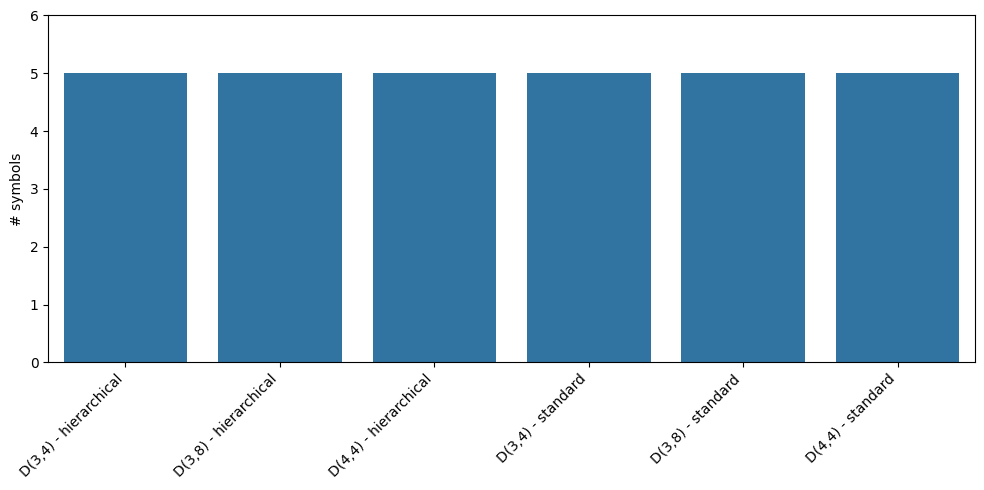

In [28]:
plt.figure(figsize=(10, 5))

seaborn.barplot(
    data=df_ml,
    x="dataset",
    y="message length",
    errorbar="ci",
    estimator=np.mean
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("# symbols")
plt.xlabel("")
plt.ylim(0, 6)
plt.tight_layout()
plt.show()


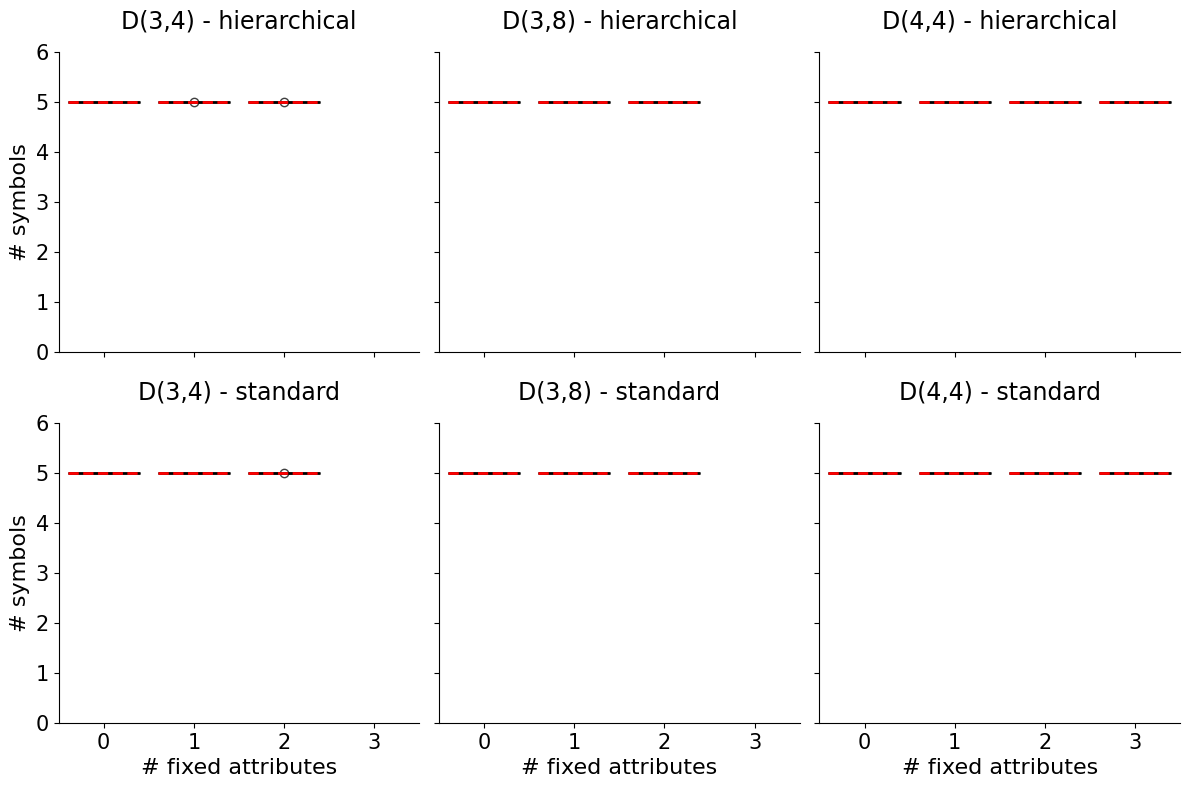

In [21]:
# Create a FacetGrid
g = seaborn.FacetGrid(pd.DataFrame(df_ml_hierarchical), col="dataset", col_wrap=3, sharey=True, height=4)
# Map the boxplot to each subplot in the grid
g.map(seaborn.boxplot, "level", "message length", order=range(4), showmeans=True, meanline=True, meanprops=dict(color="red", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
g.set_titles(col_template="{col_name}", fontsize=50)
g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize=17, y=1.05)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim(0,6)
    ax.yaxis.set_ticks([0,1,2,3,4,5,6])
g.tight_layout()
plt.show()

## 3) Model simulations (12 points)
Think about which conditions (i.e., settings) you need to compare to discuss whether the implementation of the hierarchical dataset has any measurable impact on the emerging language. Specify which conditions you will compare and why and state your hypotheses. Simulate five runs for each of the datasets and each of the conditions. For hyperparameters, it is recommended to either stick to hyperparameters that were used before (check publications or default settings) or do a grid search over hyperparameters if you expect different hyperparameters to work better.

## 4) Analysis (50 points)
### 4.1) Model performance (10 points)
Assess the model performance for each dataset and condition.
### 4.2) Quantitative analysis (25 points)
Analyze the emerging languages in your conditions with metrics as you see fit. You can check out the emergent-abstractions github repository for inspiration. Your analysis should at least include the following metrics:
- NMI
- message length

Choose two additional metrics or types of quantitative analysis and interpret all your results.

### 4.3) Qualitative analysis (15 points)
Look at the emerging messages and concepts from the interaction files (see tutorial). Assess the differences between simulations with and without the hierarchical datasets. Can you make out specific test cases where the results (should) differ? Come up with a good way to visualize your results, either as a tidy table, or a visual representation, for example with clustering methods.

Conditions of interest:


## 5) Discussion (20 points)
Summarize your results and discuss whether the hierarchical dataset implementation resulted in measurable differences in the emerging language.

## Bonus task (15 bonus points)
You receive 15 bonus points for trying to replicate the above-mentioned study by [Hawkins et al. (2018)](https://escholarship.org/uc/item/81s4d7fv) with a hierarchical dataset. This can be done in the scope of the assignments above. Suitable parameters for creating datasets with different context granularities are implemented in the main Github repository and can be used for this task. Make sure to present an analysis and discussion linking the simulation results to results from the paper.

## X) Reflection (no points, but mandatory)

Reflect on your group work. What went well? What did not go well?

Please note down the group members' team roles anonymously and reflect on how you filled this role.